Statscore to get live play by play data

Assumptions:
1. The theoretical probability of an event A happening and not happening should add up to 1. From this we can derive two important relationships. look at picture
- buying a Yes contract is the same as selling a No contract <=> selling a Yes contract is the same as buying a No contract
2. If TV(no) + TV(yes) is not equal to 1 (i.e. less than or greater than 1), this presents a trading opportunity
3. If the "Yes" market moves up, we expect the "No" market to move down (to sum to 1) and vice versa. In particular, when they don't sum to 1, we can interpret the market that changed first as a signal that the complement market will move in the opposite direction.
4. (arbitrage) If the higher spread of total score has higher TV than a lower spread, and I can buy the lower spread and sell at the higher spread, this is classic arbitrage
    - would be interesting to see if this happens -- probably closer to end of game when markets are more liquid and tigheter if it does happen.
5. if a team is in the redzone, we can determine the probability p that the team scores a touchdown, which will change the spread of the game score, and trade accordingly
6. spread strategy: the TV of lower spread should be higher than the TV of higher spread (i.e the prbability of the spread of the score being >8.5 should be higher than the probability of the spread being >9.5) (would be better to look at critical spreads like >6.5, 13.5, etc). This is often not the case. They could be equal or the higher spread could have a higher TV than the lower spread. Then either the lower spread is priced too low or if the higher spread is priced too high. We should buy the Yes contract of the lower spread and buy the No contract of the higher spread, expecting the difference of the TVs to be greater than 0 (TV(lower spread) - TV(higher spread) > 0). exit at a threshold.
7. linear regression between implied probabilities pulled from different books vs probabilities in kalshi


In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv("../data_collection/updated_scripts/kalshi_data_logs/kalshi_data_11-01.csv")
df.head()

,timestamp,ticker,title,status,market_type,yes_bid,yes_bid2,yes_ask,yes_ask2,no_bid,no_bid2,no_ask,no_ask2,yes_spread,no_spread,yes_depth,no_depth,liquidity_dollars,volume_24h
0,2025-11-01T00:00:00.658581Z,KXNFLGAME-25NOV02KCBUF-BUF,Kansas City at Buffalo Winner?,active,binary,0.46,0.98,0.47,0.02,0.53,0.98,0.54,0.02,0.01,0.01,44,48,8176201.94,32012.0
1,2025-11-01T00:00:00.755093Z,KXNFLGAME-25NOV02KCBUF-KC,Kansas City at Buffalo Winner?,active,binary,0.54,0.98,0.55,0.02,0.45,0.98,0.46,0.02,0.01,0.01,51,40,7441777.89,86484.0
2,2025-11-01T00:00:00.842364Z,KXNFLGAME-25NOV02LACTEN-LAC,Los Angeles C at Tennessee Winner?,active,binary,0.81,0.98,0.82,0.02,0.18,0.98,0.19,0.02,0.01,0.01,81,18,6070234.86,39507.0
3,2025-11-01T00:00:00.927007Z,KXNFLGAME-25NOV02NOLA-LA,New Orleans at Los Angeles R Winner?,active,binary,0.89,0.98,0.90,0.02,0.10,0.98,0.11,0.02,0.01,0.01,84,10,5615515.57,15247.0
4,2025-11-01T00:00:01.024389Z,KXNFLGAME-25NOV02CARGB-GB,Carolina at Green Bay Winner?,active,binary,0.87,0.98,0.88,0.02,0.12,0.98,0.13,0.02,0.01,0.01,85,12,5597237.98,18797.0


In [31]:
df.drop(columns=['market_type', 'yes_bid2', 'yes_ask2', 'no_bid2', 'no_ask2'], inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
is_nfl = df['ticker'].str.contains(r'^KXNFL', regex=True)
is_nba = df['ticker'].str.contains(r'^KXNBA', regex=True)
df['ticker'] = df['ticker'].str.split('-').str[-1]


# Split into two dataframes
df_nfl = df[is_nfl].copy()
df_nba = df[is_nba].copy()

In [38]:
df_nba.head()

,timestamp,ticker,title,status,yes_bid,yes_ask,no_bid,no_ask,yes_spread,no_spread,yes_depth,no_depth,liquidity_dollars,volume_24h
26,2025-11-01 00:00:03.025051+00:00,LAC,New Orleans vs Los Angeles C Winner?,active,0.82,0.83,0.17,0.18,0.01,0.01,45,12,892680.81,98346.0
27,2025-11-01 00:00:03.109705+00:00,PHX,Utah vs Phoenix Winner?,active,0.58,0.59,0.41,0.42,0.01,0.01,37,15,523898.36,96480.0
28,2025-11-01 00:00:03.194521+00:00,UTA,Utah vs Phoenix Winner?,active,0.41,0.42,0.58,0.59,0.01,0.01,34,20,502341.16,96387.0
29,2025-11-01 00:00:03.276931+00:00,LAL,Los Angeles L vs Memphis Winner?,active,0.55,0.56,0.44,0.45,0.01,0.01,42,17,441851.26,422848.0
30,2025-11-01 00:00:03.364856+00:00,NOP,New Orleans vs Los Angeles C Winner?,active,0.18,0.19,0.81,0.82,0.01,0.01,18,23,411718.49,188593.0


In [39]:
df_buf = df_nfl.loc[df['ticker']=='LAC']
df_buf = df_buf.sort_values('timestamp')
df_buf.head()

,timestamp,ticker,title,status,yes_bid,yes_ask,no_bid,no_ask,yes_spread,no_spread,yes_depth,no_depth,liquidity_dollars,volume_24h
2,2025-11-01 00:00:00.842364+00:00,LAC,Los Angeles C at Tennessee Winner?,active,0.81,0.82,0.18,0.19,0.01,0.01,81,18,6070234.86,39507.0
52,2025-11-01 00:00:20.524264+00:00,LAC,Los Angeles C at Tennessee Winner?,active,0.81,0.82,0.18,0.19,0.01,0.01,81,18,6069951.78,39507.0
102,2025-11-01 00:00:40.193475+00:00,LAC,Los Angeles C at Tennessee Winner?,active,0.81,0.82,0.18,0.19,0.01,0.01,81,18,6069951.78,39507.0
152,2025-11-01 00:00:59.982238+00:00,LAC,Los Angeles C at Tennessee Winner?,active,0.81,0.82,0.18,0.19,0.01,0.01,81,18,6069732.35,39507.0
202,2025-11-01 00:01:19.651079+00:00,LAC,Los Angeles C at Tennessee Winner?,active,0.81,0.82,0.18,0.19,0.01,0.01,81,18,6069732.35,39507.0


In [40]:
df_buf.iloc[-1]

timestamp              2025-11-01 20:12:05.089671+00:00
ticker                                              LAC
title                Los Angeles C at Tennessee Winner?
status                                           active
yes_bid                                            0.81
yes_ask                                            0.82
no_bid                                             0.18
no_ask                                             0.19
yes_spread                                         0.01
no_spread                                          0.01
yes_depth                                            81
no_depth                                             18
liquidity_dollars                            6257091.85
volume_24h                                      59215.0
Name: 183402, dtype: object

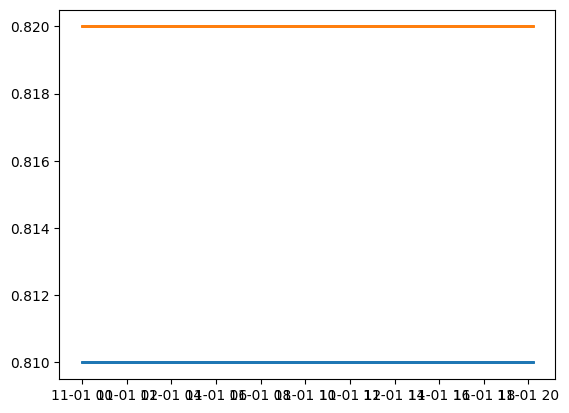

In [41]:
plt.scatter(df_buf['timestamp'], df_buf['yes_bid'], s=1)
plt.scatter(df_buf['timestamp'], df_buf['yes_ask'], s=1)
plt.show()